In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import segyio
import scipy.signal
import scipy.interpolate
from scipy.interpolate import interp1d
import pylops
import seaborn as sns
import cmocean as cm
import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

In [2]:
print('Numpy', np.__version__)
print('Scipy', scipy.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', matplotlib.__version__)
print('Pylops', pylops.__version__)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
Numpy 1.22.0
Scipy 1.8.0
Pandas 2.0.3
Matplotlib 3.7.2
Pylops 2.1.0


In [3]:
#Loading seismic using Segyio lib

# string containing the path location of the seismic data at disk
segy_file_path = '..\Seismic\TIME_R0321_COMPLEX_ALBACORA_PSDM_4ms.segy'

#loading stack using Segyio lib
stack = segyio.open(segy_file_path,iline=segyio.TraceField.INLINE_3D, 
                xline=segyio.tracefield.TraceField.CROSSLINE_3D) 
#Allocating IL, XL, Time axis in variables
il, xl, t = stack.ilines, stack.xlines, stack.samples
#Measuring Sample rate from data samples
dt = t[1] - t[0]
#Creating seismic cube format using segyio cube method
data_cube = segyio.cube(stack)
#Qc of the axis shapes
nil, nxl, nt = data_cube.shape

# Inlines information
il_start, il_end = il[0], il[-1]
    
# Crosslines information
xl_start, xl_end = xl[0], xl[-1]

In [4]:
print('Seismic amplitude data information \n --------------------------------------------------')
print('Shape of data [n_il, n_xl, n_samples]: ', nil, nxl, nt)
print('Inline start:', il_start, '    ', 'Inline end:', il_end)
print('Crossline start:', xl_start, '    ', 'Crossline end:', xl_end)
print('Sample rate [ms]:', dt)
print('Number of samples by trace:', stack.tracecount)      
print('Two-way-time array:', t)

Seismic amplitude data information 
 --------------------------------------------------
Shape of data [n_il, n_xl, n_samples]:  1798 1995 1695
Inline start: 1366      Inline end: 3163
Crossline start: 1713      Crossline end: 3707
Sample rate [ms]: 3.99
Number of samples by trace: 3587010
Two-way-time array: [0.00000e+00 3.99000e+00 7.98000e+00 ... 6.75108e+03 6.75507e+03
 6.75906e+03]


In [5]:
filename = "../Low_Frequency_Model_Data/LF_Model_Angle45.sgy"

In [6]:
segy_file_path = filename

#loading stack using Segyio lib
m0 = segyio.open(segy_file_path,iline=segyio.TraceField.INLINE_3D, 
                xline=segyio.tracefield.TraceField.CROSSLINE_3D) 
#Allocating IL, XL, Time axis in variables
m0_il, m0_xl, m0_t = m0.ilines, m0.xlines, m0.samples
#Measuring Sample rate from data samples
m0_dt = m0_t[1] - m0_t[0]
#Creating seismic cube format using segyio cube method
m0_cube = segyio.cube(m0)
#Qc of the axis shapes
m0_nil, m0_nxl, m0_nt = m0_cube.shape

# Inlines information
m0_il_start, m0_il_end = m0_il[0], m0_il[-1]
    
# Crosslines information
m0_xl_start, m0_xl_end = m0_xl[0], m0_xl[-1]

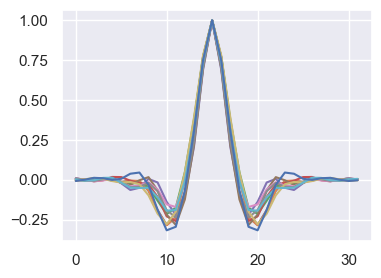

In [7]:
# Wavelet

path = "..\Inputs\\Wavelets\\"
wavs = np.zeros((11, 32))
times = np.zeros((11, 32))
for idx, file in enumerate(os.listdir(path)):
    arr = pd.read_csv(path+file, skiprows=16, sep='\s+').to_numpy()
    wavs[idx, :] = arr[:, 1] / np.max(abs(arr[:, 1]))
    times[idx, :] = arr[:, 0]

    
plt.figure(figsize=(4, 3))
for i in range(11):
    #plt.plot(times[i, :], wavs[i, :])
    plt.plot(wavs[i, :])    

In [8]:
wav = np.mean(wavs, axis=0)
wav = wav / np.max(abs(wav))
wav = np.concatenate((wav[0:17], wav[0:14][::-1]), axis=0)

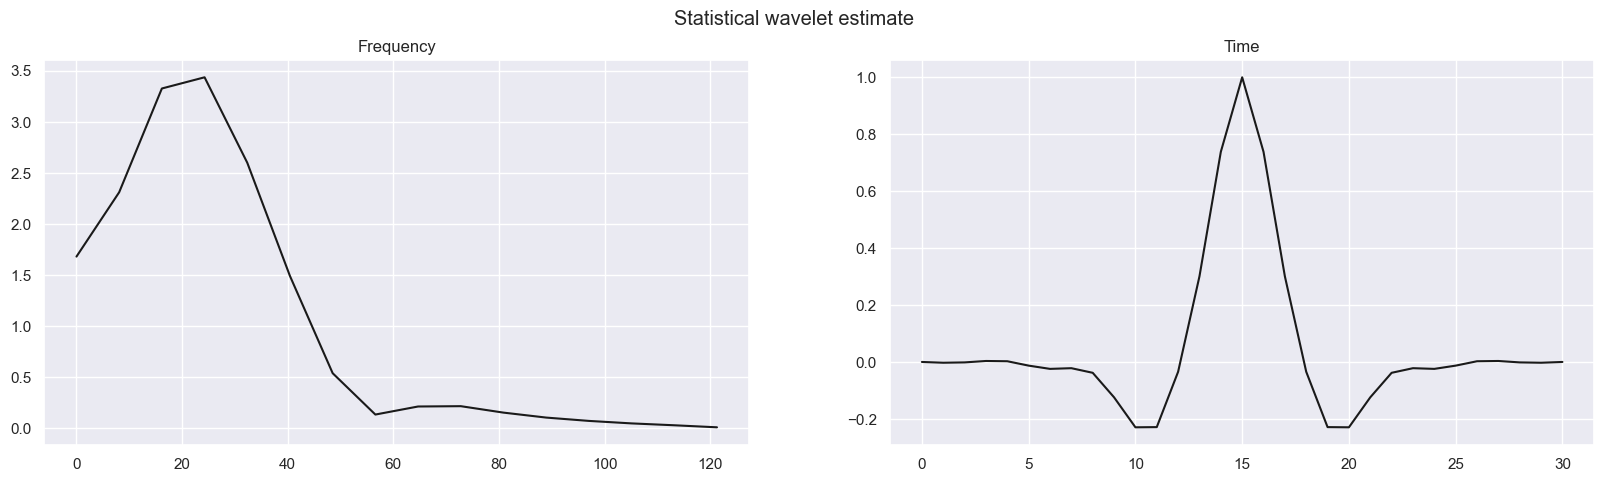

In [9]:

wav = np.mean(wavs, axis=0)
wav = wav / np.max(abs(wav))
wav = np.concatenate((wav[0:17], wav[0:14][::-1]), axis=0)  

freqs = np.fft.rfftfreq(times.shape[1]-1, d=dt/1000)
a = np.fft.rfft(wav)
A = np.abs(a)

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(freqs, A, 'k')
axs[0].set_title('Frequency')
axs[1].plot( wav, 'k')
axs[1].set_title('Time');

In [10]:
len(wav)

31

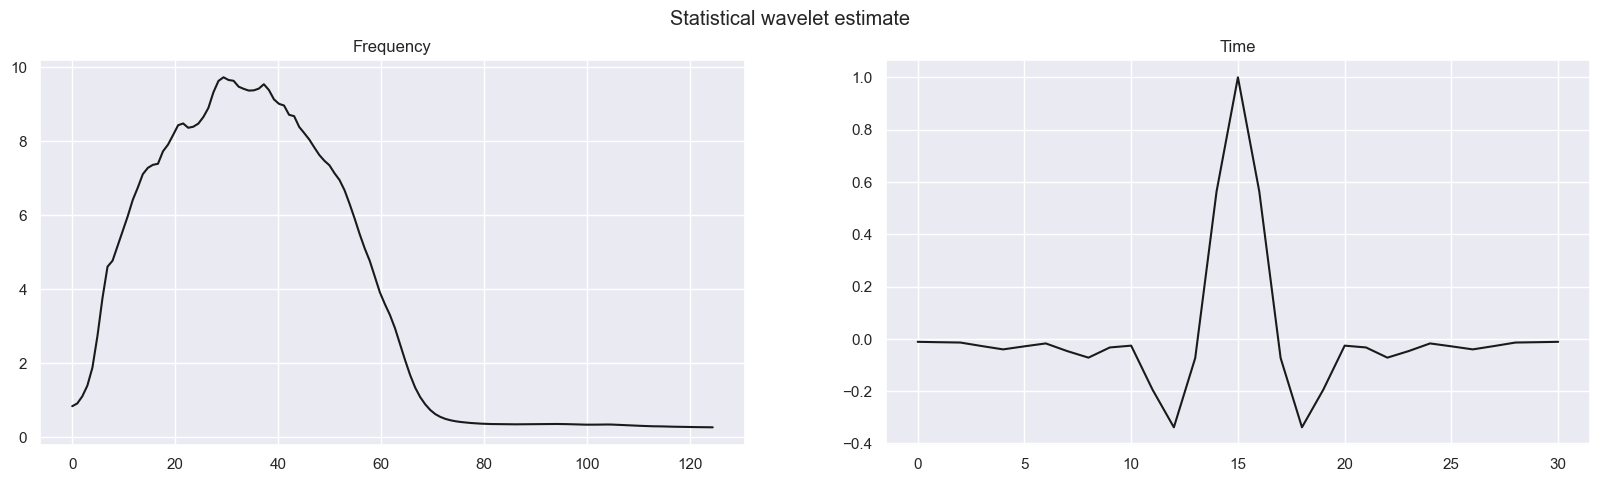

In [11]:
#Another wavelet estimation method

nt_wav = 16 # lenght of wavelet in samples
nfft = 2**8 # lenght of fft

# time axis for wavelet
t_wav = np.arange(nt_wav) * (dt/1000) 
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(data_cube[..., 425:1025], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wcenter = np.argmax(np.abs(wav_est))

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(wav_est, 'k')
axs[1].set_title('Time');

In [12]:
len(wav_est)

31

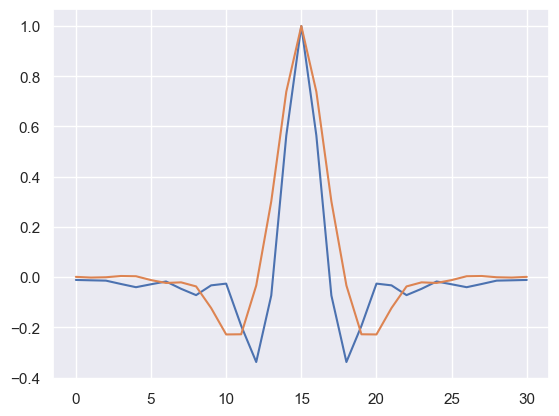

In [13]:
plt.plot(wav_est)
plt.plot(wav)

In [14]:
topo = pd.read_csv("..\Horizons\\MAIO_23_updated\\ABL_140_TOPO_updated.dat",
                 sep='\s+', usecols=(0, 1, 4), names=['X', 'Y', 'Z'])
topo_surface = np.full((nil, nxl), np.nan, dtype=np.float32)
ils = np.arange(il_start, il_end+1, 1, dtype=int)
xls = np.arange(xl_start, xl_end+1, 1, dtype=int) 
for idx, inline in enumerate(ils):
    x = topo.loc[topo.X == inline].Y
    y = topo.loc[topo.X == inline].Z
    interp = interp1d(x, y, bounds_error=False, fill_value='extrapolate')
    topo_surface[idx, :] = interp(xls)
    print(f'Inline {inline}/{ils[-1]}\r', end="")   
topo_surface = topo_surface.T

base = pd.read_csv("..\Horizons\\IN_XLINES\\BASE_AB_140_SEISWORKS.dat",
                 sep='\s+', usecols=(0, 1, 4), names=['X', 'Y', 'Z'])
base_surface = np.full((nil, nxl), np.nan, dtype=np.float32)
ils = np.arange(il_start, il_end+1, 1, dtype=int)
xls = np.arange(xl_start, xl_end+1, 1, dtype=int) 
for idx, inline in enumerate(ils):
    x = base.loc[base.X == inline].Y
    y = base.loc[base.X == inline].Z
    interp = interp1d(x, y, bounds_error=False, fill_value='extrapolate')
    base_surface[idx, :] = interp(xls)
    print(f'Inline {inline}/{ils[-1]}\r', end="")    
base_surface = base_surface.T

mazul = pd.read_csv("..\Horizons\\IN_XLINES\\MAZUL_SEISWORKS.dat",
                 sep='\s+', usecols=(0, 1, 4), names=['X', 'Y', 'Z'])
mazul_surface = np.full((nil, nxl), np.nan, dtype=np.float32)
ils = np.arange(il_start, il_end+1, 1, dtype=int)
xls = np.arange(xl_start, xl_end+1, 1, dtype=int) 
for idx, inline in enumerate(ils):
    x = mazul.loc[mazul.X == inline].Y
    y = mazul.loc[mazul.X == inline].Z
    
    interp = interp1d(x, y, bounds_error=False, fill_value='extrapolate')
    
    mazul_surface[idx, :] = interp(xls)
    
    print(f'Inline {inline}/{ils[-1]}\r', end="")
mazul_surface = mazul_surface.T

topo_surface_shift = topo_surface - 180

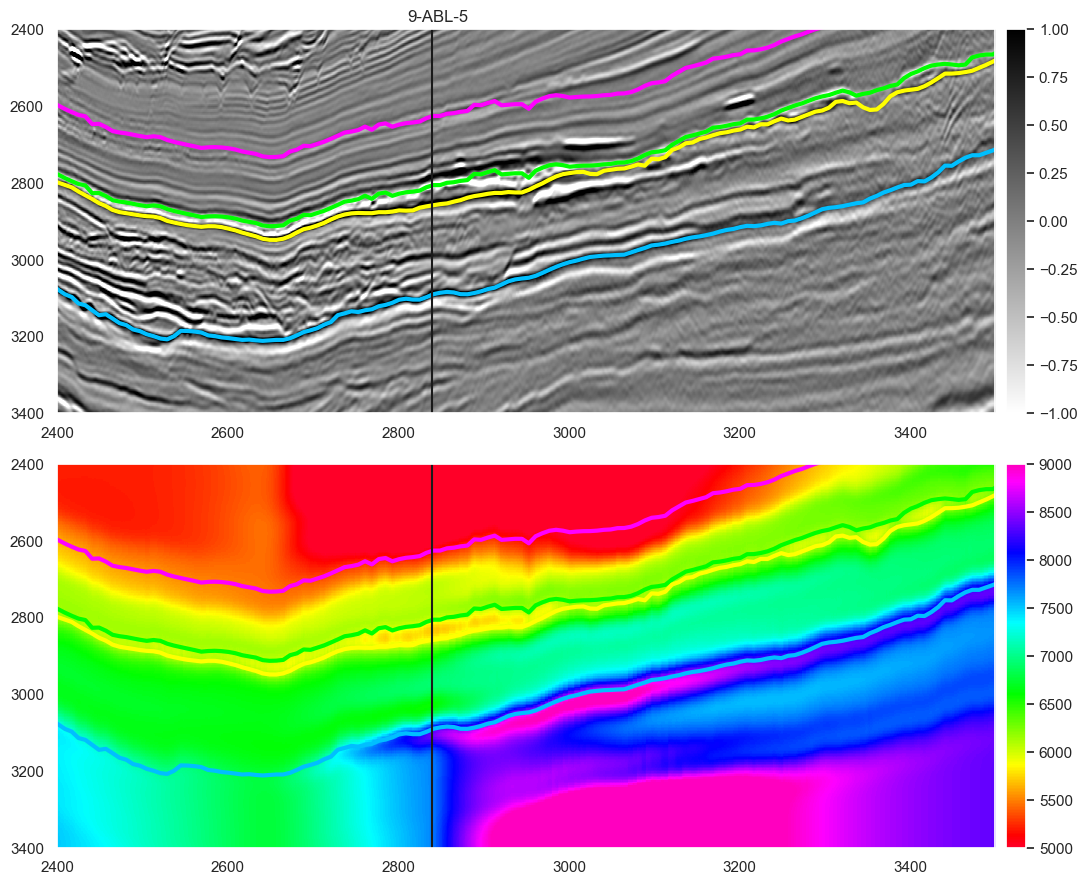

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(12, 9))

c=ax[0].imshow(data_cube[2594-il_start, :, :].T, aspect='auto', cmap='gray_r', vmin=-1, vmax=1,
            extent=[xl_start, xl_end, t[-1], t[0]])
plt.colorbar(c, ax=ax[0], pad=0.01)
ax[0].text(2810, 2380, '9-ABL-5')
c=ax[1].imshow(m0_cube[2594-il_start, :, :].T, aspect='auto', extent=[xl_start, xl_end, 6780, 0],
          alpha=1.0, cmap='gist_rainbow', vmin=5000, vmax=9000, interpolation='nearest')
plt.colorbar(c, ax=ax[1], pad=0.01)

for axs in (ax[0], ax[1]):
    axs.plot(topo.loc[topo.X == 2594].Y, topo.loc[topo.X == 2594].Z,
             color='lime', lw=3.0)
    axs.plot(base.loc[base.X == 2594].Y, base.loc[base.X == 2594].Z,
             color='yellow', lw=3.0)
    axs.plot(mazul.loc[mazul.X == 2594].Y, mazul.loc[mazul.X == 2594].Z,
             color='deepskyblue', lw=3.0)
    axs.plot(topo.loc[topo.X == 2594].Y, topo.loc[topo.X == 2594].Z - 180,
             color='magenta', lw=3.0)

    axs.axvline(2839, color='k')
    axs.set_xlim(2400, 3500)
    axs.set_ylim(3400, 2400)
    axs.grid(False)
    
plt.tight_layout()

In [16]:
path = "..\Wells_LowFreq/Wells/"
path2 = "..\Wells_LowFreq/TDR/"
skips = [50, 62, 86, 85, 86, 86, 87, 80, 79]
df = pd.DataFrame()

for idx, file in enumerate(os.listdir(path)):
    
    print(file)
    
    if file=='4-RJS-477A-RJ_BEST-SET.las':
         well = pd.read_csv(path+file, sep='\s+', skiprows=62, usecols=(0, 1, 7), names=['MD', 'FACIES', 'IP'])
    else:
        well = pd.read_csv(path+file, sep='\s+', skiprows=skips[idx], names=['MD', 'FACIES', 'IP'])
    well.replace(-9999.0, np.nan, inplace=True)
    well['IP'] = well['IP'] * 1000
    well['WELL'] = file.split('_')[0]
    #print(well)
    
    tdr_name = ''
    for j, f in enumerate(file.split('-')[0:3]):
        tdr_name += f
        if j != 2:
            tdr_name += '-'
    
    if tdr_name != '4-RJS-477A':
        tdr = pd.read_csv(path2+'TDR_'+tdr_name+'.csv', sep=';', usecols=(1, 2))
        tdr['TWT'] = 2*tdr.OWT.to_numpy()
    else:
        print(path2+'TDR_'+tdr_name+'.txt')
        tdr = pd.read_csv(path2+'TDR_'+tdr_name+'.txt', sep='\s+', skiprows=14, usecols=(3, 4), names=['TWT', 'MD'])
        tdr['TWT'] = tdr['TWT'] * -1
    
    
    #print(well)
    
    interp_tdr = interp1d(tdr['MD'], tdr['TWT'], fill_value='extrapolate', bounds_error=False)
    t_well = interp_tdr(well.MD)
    
    new_samples = np.arange(1700, 4100, 4)
    interp2 = interp1d(t_well, well.IP, bounds_error=False, fill_value='extrapolate')
    ip_ups = interp2(new_samples)
    ip_ups_smooth = scipy.ndimage.gaussian_filter1d(ip_ups, sigma=1.2)
    
    arr = np.array([new_samples, ip_ups, ip_ups_smooth])
    nwell = pd.DataFrame(arr.T, columns=['TWT', 'IP_UPS', 'IP_UPS_SMOOTH'])
    nwell['WELL'] = file.split('_')[0]
    nwell['IP_UPS'] = nwell['IP_UPS'].fillna(method='bfill').fillna(method='ffill')
    # Concatenate
    df = pd.concat([df, nwell], ignore_index=True)

3-RJS-360A-RJS_BEST_SET.las
4-RJS-477A-RJ_BEST-SET.las
..\Wells_LowFreq/TDR/TDR_4-RJS-477A.txt
9-ABL-2-RJS_BEST_SET.las
9-ABL-3B-RJS_BEST_SET.las
9-ABL-5-RJS_BEST_SET.las
9-ABL-6A-RJS_BEST_SET.las
9-ABL-7-RJS_BEST_SET.las
9-ABL-83D-RJS_BEST_SET.las
9-ABL-9D-RJS_BEST_SET.las


In [17]:
rel_positions = [
    [2985 - xl_start, 2510 - il_start], # 360A
    [3228 - xl_start, 2255 - il_start], # 477A
    [2929 - xl_start, 2650 - il_start], # 9ABL2
    [2994 - xl_start, 2301 - il_start], # 9ABL3B
    [2839 - xl_start, 2594 - il_start], # 9ABL5
    [2768 - xl_start, 2694 - il_start], # 9ABL6A
    [2926 - xl_start, 2450 - il_start], # 9ABL7
    [2665 - xl_start, 2615 - il_start], # 9ABL83D
    [2754 - xl_start, 2253 - il_start], # 9ABL9D
]

wells_names = [
'360A',
'477A',
'9ABL2',
'9ABL3B',
'9ABL5',
'9ABL6A',
'9ABL7',
'9ABL83D',
'9ABL9D',
]

In [18]:
print(len(wav))
print(len(wav_est))

31
31


In [19]:
# Inverting at well 9 ABLL 5 inline

# Seismic amplitude section
amp = data_cube[2594 - il_start, :, 425:1025].T
print("Shape of data [n_samples, n_traces]:", amp.shape)
# Log of the low frequency model of impedance
mback = np.log(m0_cube[2594 - il_start, :, 425:1025].T)
# Wavelet operator
nz, nx = amp.shape
PPop = pylops.avo.poststack.PoststackLinearModelling(wav/2,
                                                     nt0=nz,
                                                     spatdims=nx,
                                                     explicit=True)

# Trace-by-trace
minv_tbt, istop = pylops.optimization.leastsquares.normal_equations_inversion(
    Op=PPop,
    y=amp.ravel() / 10,
    Regs=None,
    epsI=4e-1,
    x0=mback.ravel(),
    engine='scipy',
    show=True,
    **dict(maxiter=1000))
minv_tbt = np.exp(mback + minv_tbt.reshape(nz, nx))

Shape of data [n_samples, n_traces]: (600, 1995)
NormalEquationsInversion
-------------------------------------------------------
The Operator Op has 1197000 rows and 1197000 cols
Regs=None
epsRs=None     epsI=0.4
-------------------------------------------------------


In [20]:
df.WELL.unique()

array(['3-RJS-360A-RJS', '4-RJS-477A-RJ', '9-ABL-2-RJS', '9-ABL-3B-RJS',
       '9-ABL-5-RJS', '9-ABL-6A-RJS', '9-ABL-7-RJS', '9-ABL-83D-RJS',
       '9-ABL-9D-RJS'], dtype=object)

In [21]:
ip_mask = np.full_like(m0_cube[:, :, 2594-il_start].T, np.nan)
for i in range(len(ip_mask)):
    tss = topo_surface_shift[i, 2594-il_start]
    mas = mazul_surface[i, 2594-il_start]

    ip_mask[i, int((tss-1700)//4):int((mas-1700)//4)+1] = 1

    print(f"{i}\r", end="")

In [23]:
ip_mask.shape

(1995, 1798)

In [22]:
img = np.tile(df.loc[df.WELL=='9-ABL-5-RJS'].IP_UPS, (100, 1))

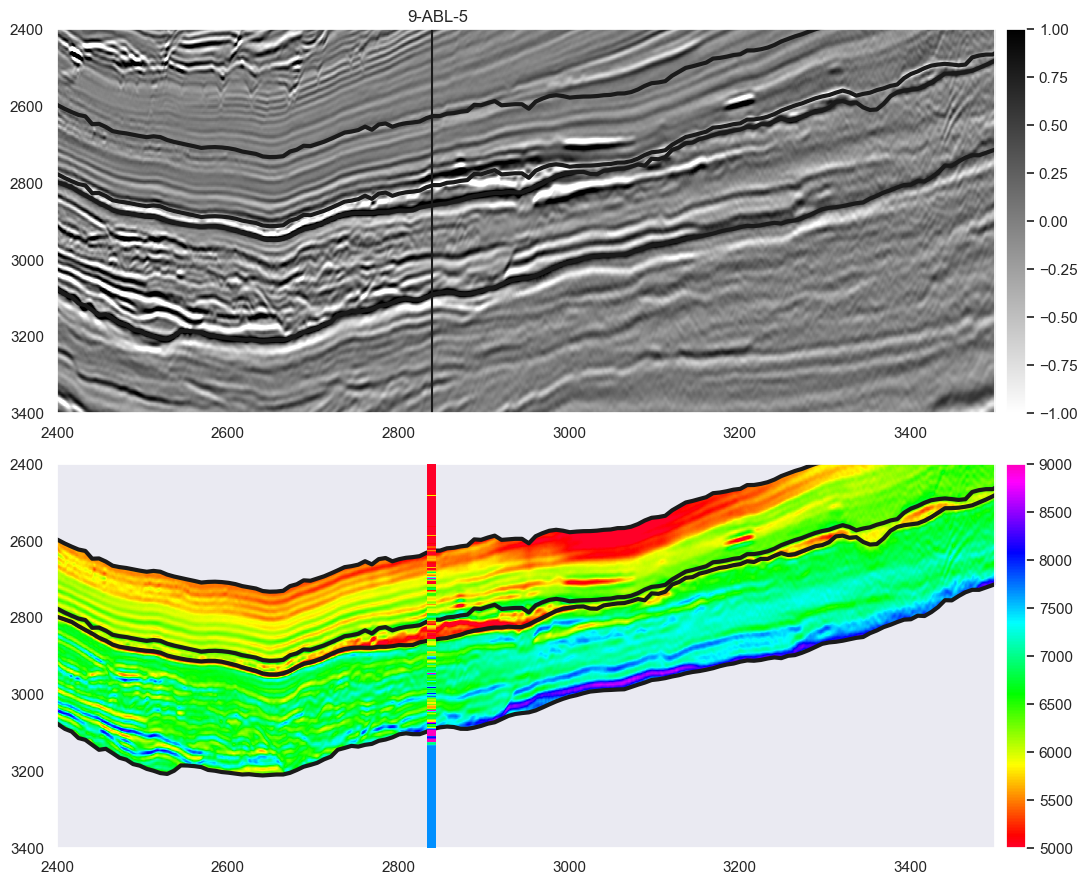

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(12, 9))

c=ax[0].imshow(data_cube[2594-il_start, :, :].T, aspect='auto', cmap='gray_r', vmin=-1, vmax=1,
            extent=[xl_start, xl_end, t[-1], t[0]])
#c=ax[0].imshow(minv_tbt * ip_mask[:, 0:600].T, aspect='auto', extent=[xl_start, xl_end, 4100, 1700],
#          alpha=0.4, cmap='gist_rainbow', vmin=5000, vmax=9000)
plt.colorbar(c, ax=ax[0], pad=0.01)
ax[0].text(2810, 2380, '9-ABL-5')
c=ax[1].imshow(minv_tbt * ip_mask[:, 0:600].T, aspect='auto', extent=[xl_start, xl_end, 4100, 1700],
          alpha=1.0, cmap='gist_rainbow', vmin=5000, vmax=9000)
plt.colorbar(c, ax=ax[1], pad=0.01)

ax[1].imshow(img.T, aspect='auto', cmap='gist_rainbow', vmin=5000, vmax=9000,
             extent=(2839-5, 2839+5, 4100, 1700), zorder=20)

for axs in (ax[0], ax[1]):
    axs.plot(topo.loc[topo.X == 2594].Y, topo.loc[topo.X == 2594].Z,
             color='k', lw=3.0)
    axs.plot(base.loc[base.X == 2594].Y, base.loc[base.X == 2594].Z,
             color='k', lw=3.0)
    axs.plot(mazul.loc[mazul.X == 2594].Y, mazul.loc[mazul.X == 2594].Z,
             color='k', lw=3.0)
    axs.plot(topo.loc[topo.X == 2594].Y, topo.loc[topo.X == 2594].Z - 180,
             color='k', lw=3.0)

    axs.axvline(2839, color='k')
    axs.set_xlim(2400, 3500)
    axs.set_ylim(3400, 2400)
    axs.grid(False)
    
plt.tight_layout()

In [37]:
# Inverting at well 9 ABLL 5 inline

# Seismic amplitude section
amp = data_cube[2594 - il_start, :, 425:1025].T
print("Shape of data [n_samples, n_traces]:", amp.shape)
# Log of the low frequency model of impedance
mback = np.log(m0_cube[2594 - il_start, :, 425:1025].T)
# Wavelet operator
nz, nx = amp.shape
PPop_wav_est_fft = pylops.avo.poststack.PoststackLinearModelling(wav_est/2,
                                                     nt0=nz,
                                                     spatdims=nx,
                                                     explicit=True)

# Trace-by-trace
minv_tbt_wav_fft_est, istop_wav_fft_est = pylops.optimization.leastsquares.normal_equations_inversion(
    Op=PPop_wav_est_fft,
    y=amp.ravel() / 10,
    Regs=None,
    epsI=4e-1,
    x0=mback.ravel(),
    engine='scipy',
    show=True,
    **dict(maxiter=1000))
minv_tbt_wav_fft_est = np.exp(mback + minv_tbt_wav_fft_est.reshape(nz, nx))

Shape of data [n_samples, n_traces]: (600, 1995)
NormalEquationsInversion
-------------------------------------------------------
The Operator Op has 1197000 rows and 1197000 cols
Regs=None
epsRs=None     epsI=0.4
-------------------------------------------------------


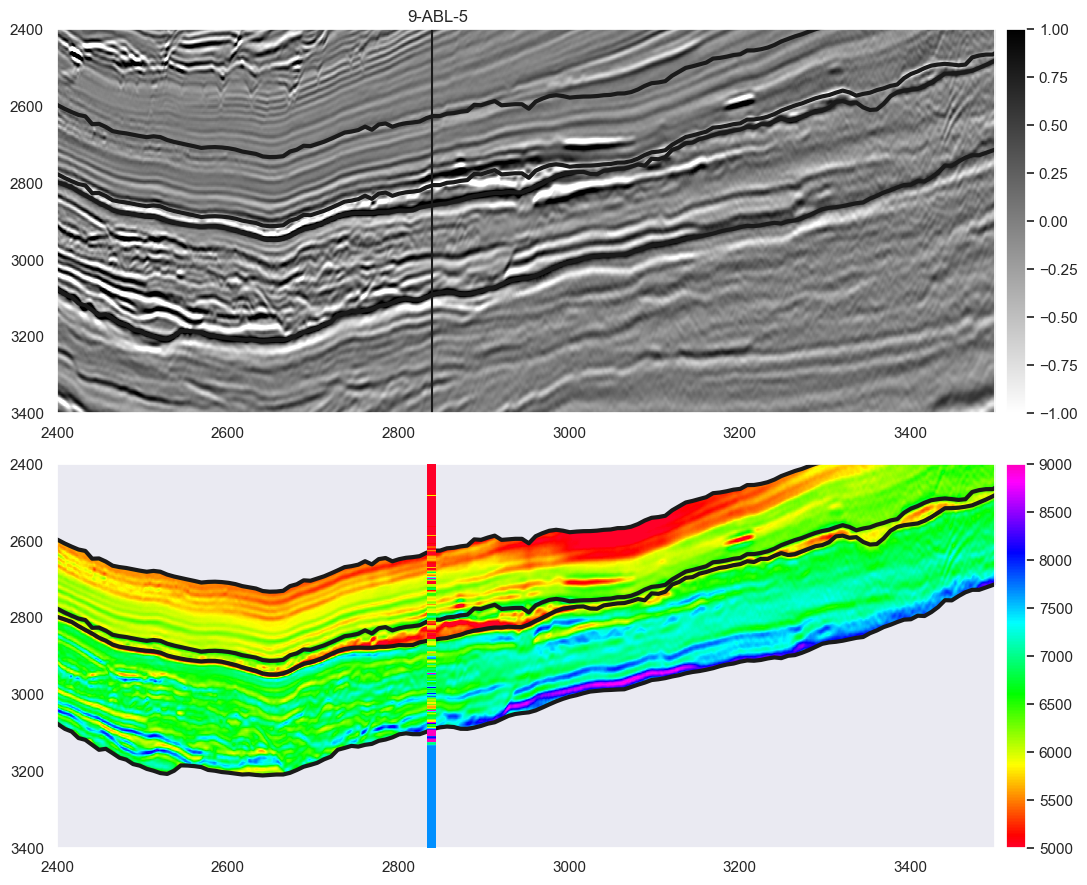

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(12, 9))

c=ax[0].imshow(data_cube[2594-il_start, :, :].T, aspect='auto', cmap='gray_r', vmin=-1, vmax=1,
            extent=[xl_start, xl_end, t[-1], t[0]])
#c=ax[0].imshow(minv_tbt_wav_fft_est * ip_mask[:, 0:600].T, aspect='auto', extent=[xl_start, xl_end, 4100, 1700],
#          alpha=0.4, cmap='gist_rainbow', vmin=5000, vmax=9000)
plt.colorbar(c, ax=ax[0], pad=0.01)
ax[0].text(2810, 2380, '9-ABL-5')
c=ax[1].imshow(minv_tbt_wav_fft_est * ip_mask[:, 0:600].T, aspect='auto', extent=[xl_start, xl_end, 4100, 1700],
          alpha=1.0, cmap='gist_rainbow', vmin=5000, vmax=9000)
plt.colorbar(c, ax=ax[1], pad=0.01)

ax[1].imshow(img.T, aspect='auto', cmap='gist_rainbow', vmin=5000, vmax=9000,
             extent=(2839-5, 2839+5, 4100, 1700), zorder=20)

for axs in (ax[0], ax[1]):
    axs.plot(topo.loc[topo.X == 2594].Y, topo.loc[topo.X == 2594].Z,
             color='k', lw=3.0)
    axs.plot(base.loc[base.X == 2594].Y, base.loc[base.X == 2594].Z,
             color='k', lw=3.0)
    axs.plot(mazul.loc[mazul.X == 2594].Y, mazul.loc[mazul.X == 2594].Z,
             color='k', lw=3.0)
    axs.plot(topo.loc[topo.X == 2594].Y, topo.loc[topo.X == 2594].Z - 180,
             color='k', lw=3.0)

    axs.axvline(2839, color='k')
    axs.set_xlim(2400, 3500)
    axs.set_ylim(3400, 2400)
    axs.grid(False)
    
plt.tight_layout()

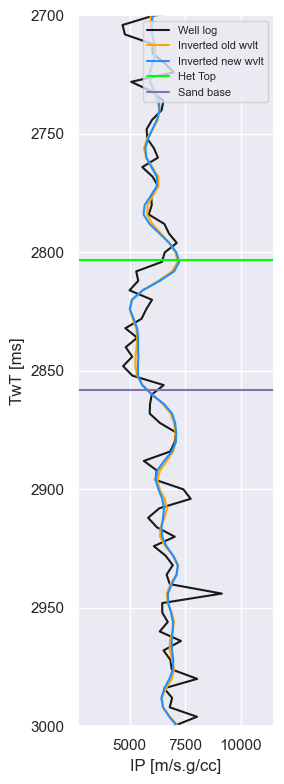

In [51]:
fig, ax = plt.subplots(figsize=(3, 8))

ax.plot(df.loc[df.WELL=='9-ABL-5-RJS'].IP_UPS, np.arange(1700, 4100, 4), color='k', label='Well log')
ax.plot(minv_tbt[:, 2839-xl_start], np.arange(1700, 4100, 4), color='orange', label='Inverted old wvlt')

ax.plot(minv_tbt_wav_fft_est[:, 2839-xl_start], np.arange(1700, 4100, 4), color='dodgerblue', label='Inverted new wvlt')

ax.axhline(2803.4, color='lime', label='Het Top')
ax.axhline(2858.244, color='m', label='Sand base')

ax.set_ylabel('TwT [ms]')
ax.set_xlabel('IP [m/s.g/cc]')

ax.set_ylim(3000, 2700)

ax.legend(fontsize=8, loc =1)

plt.tight_layout()

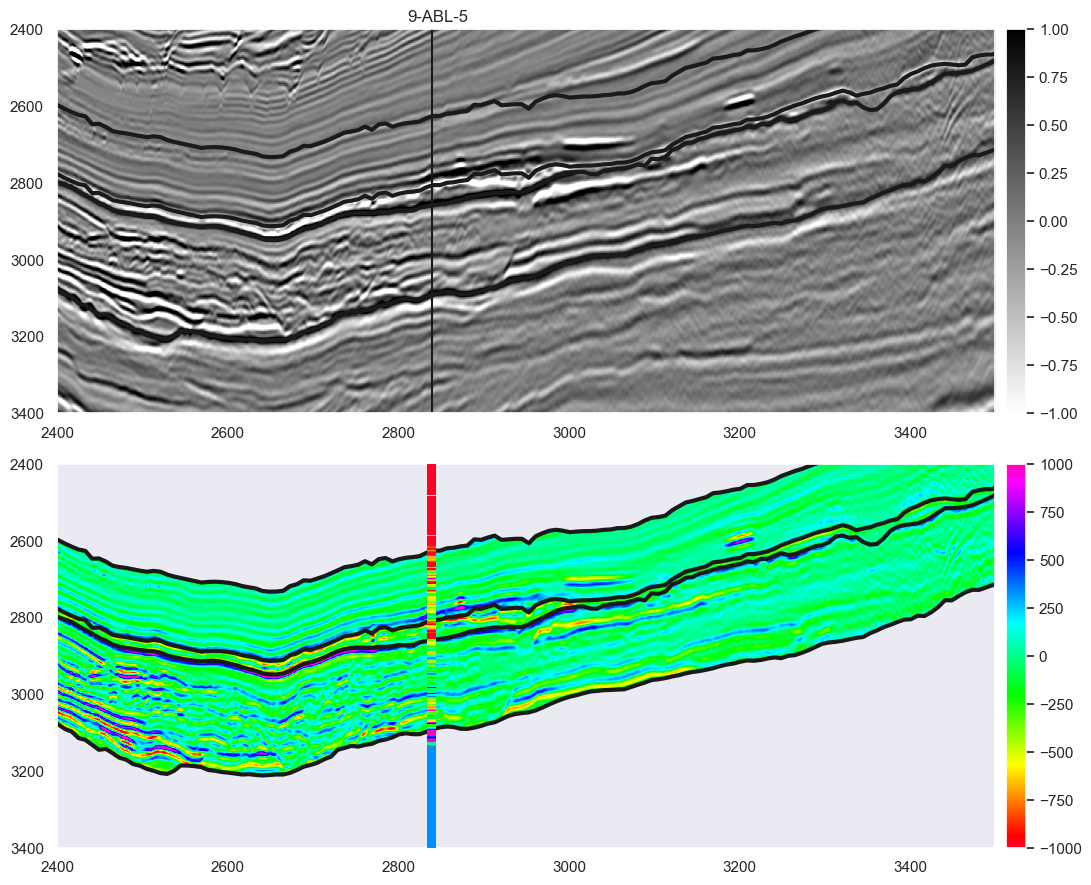

In [26]:
res = minv_tbt - minv_tbt_wav_fft_est

fig, ax = plt.subplots(2, 1, figsize=(12, 9))

c=ax[0].imshow(data_cube[2594-il_start, :, :].T, aspect='auto', cmap='gray_r', vmin=-1, vmax=1,
            extent=[xl_start, xl_end, t[-1], t[0]])
plt.colorbar(c, ax=ax[0], pad=0.01)
ax[0].text(2810, 2380, '9-ABL-5')
c=ax[1].imshow(res * ip_mask[:, 0:600].T, aspect='auto', extent=[xl_start, xl_end, 4100, 1700],
          alpha=1.0, cmap='gist_rainbow',vmin=-1000,vmax=1000)
plt.colorbar(c, ax=ax[1], pad=0.01)

ax[1].imshow(img.T, aspect='auto', cmap='gist_rainbow', vmin=5000, vmax=9000,
             extent=(2839-5, 2839+5, 4100, 1700), zorder=20)

for axs in (ax[0], ax[1]):
    axs.plot(topo.loc[topo.X == 2594].Y, topo.loc[topo.X == 2594].Z,
             color='k', lw=3.0)
    axs.plot(base.loc[base.X == 2594].Y, base.loc[base.X == 2594].Z,
             color='k', lw=3.0)
    axs.plot(mazul.loc[mazul.X == 2594].Y, mazul.loc[mazul.X == 2594].Z,
             color='k', lw=3.0)
    axs.plot(topo.loc[topo.X == 2594].Y, topo.loc[topo.X == 2594].Z - 180,
             color='k', lw=3.0)

    axs.axvline(2839, color='k')
    axs.set_xlim(2400, 3500)
    axs.set_ylim(3400, 2400)
    axs.grid(False)
    
plt.tight_layout()

In [35]:
minv_tbt.shape

(600, 1995)

In [63]:
org = df.loc[df.WELL=='9-ABL-5-RJS'].IP_UPS
est1 = minv_tbt[:, 2839-xl_start]
est2 = minv_tbt_wav_fft_est[:, 2839-xl_start]

tol = 500    

ts = ((topo_surface[2839-xl_start, 2594-il_start] - tol) - 1700)//4
bs = ((base_surface[2839-xl_start, 2594-il_start] + tol) - 1700)//4

org = org[int(ts):int(bs)]
est1 = est1[int(ts):int(bs)]
est2 = est2[int(ts):int(bs)]

mask_well = ~np.isnan(org)

r = scipy.stats.pearsonr(org[mask_well], est1[mask_well])[0]
r2 = scipy.stats.pearsonr(org[mask_well], est2[mask_well])[0]

In [64]:
print(r)
print(r2)

0.9318096377707674
0.9237190401155863
